# Time Series Forecasting with Chronos

<img src=https://demo-projects-files.s3.eu-west-1.amazonaws.com/chronos/architecture.png style="width:65%;margin-top:50px;margin-bottom:50px"/>

*Chronos architecture (source: [doi:10.48550/arXiv.2403.07815](https://doi.org/10.48550/arXiv.2403.07815))*

## Set Up

Install the dependencies.

In [1]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git transformers kaleido

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-y894v74y
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-y894v74y
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 39515ff0fcdae55bbbf546d90193dbe54b201556
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Import the dependencies.

In [2]:
import time
import torch
import transformers
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from chronos import ChronosPipeline

## Data

Get the data. 

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/daily-min-temperatures.csv",
    parse_dates=["Date"],
    dtype=float
)

In [4]:
df.shape

(3650, 2)

In [5]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


Resample the data.

In [6]:
df = df.set_index("Date").resample("MS").mean().reset_index()

In [7]:
df.shape

(120, 2)

In [8]:
df.head()

,Date,Temp
0,1981-01-01,17.712903
1,1981-02-01,17.678571
2,1981-03-01,13.500000
3,1981-04-01,12.356667
4,1981-05-01,9.490323


Visualize the data.

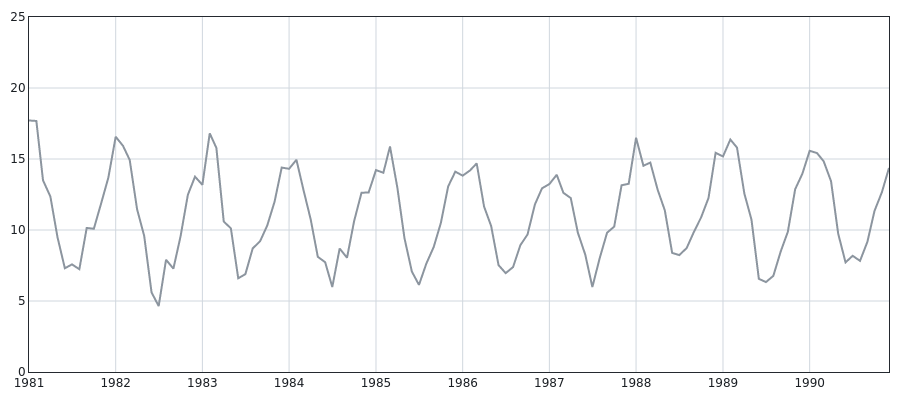

In [9]:
fig = go.Figure(
    layout=dict(
        paper_bgcolor="white",
        plot_bgcolor="white",
        margin=dict(t=10, b=10, l=10, r=10),
        width=900,
        height=400,
        xaxis=dict(
            mirror=True,
            linecolor="#24292f",
            gridcolor="#d0d7de",
            gridwidth=1,
            tickfont=dict(
                color="#1b1f24"
            ),
        ),
        yaxis=dict(
            range=[0, 25],
            mirror=True,
            linecolor="#24292f",
            gridcolor="#d0d7de",
            gridwidth=1,
            tickfont=dict(
                color="#1b1f24"
            ),
        ),
    ),
    data=[
        go.Scatter(
            x=df["Date"],
            y=df["Temp"],
            mode="lines",
            name="Actual",
            line=dict(
                color="#8c959f",
                width=2
            )
        )
    ]
)
fig.show("png")

## Model

Instantiate the model.

In [10]:
model = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

Define the prediction length.

In [11]:
prediction_length = 18

Define the number of samples.

In [12]:
num_samples = 1000

### Evaluation

Generate the test set predictions.

In [13]:
start = time.time()
transformers.set_seed(42)
yhat_test = model.predict(
    context=torch.from_numpy(df["Temp"].iloc[:-prediction_length].values),
    prediction_length=prediction_length,
    num_samples=num_samples
).detach().cpu().numpy().squeeze(axis=0)
end = time.time()
print(f"Inference time: {format(end - start, ',.2f')} seconds")

Inference time: 2.76 seconds


Organize the test set predictions in a data frame.

In [14]:
predictions = pd.DataFrame(
    data={
        "Mean": np.mean(yhat_test, axis=0),
        "Std. Dev.": np.std(yhat_test, ddof=1, axis=0),
    },
    index=df["Date"].iloc[-prediction_length:]
).reset_index()

In [15]:
predictions.head()

,Date,Mean,Std. Dev.
0,1989-07-01,7.143206,0.937785
1,1989-08-01,8.343010,0.971801
2,1989-09-01,9.337883,0.921955
3,1989-10-01,10.664992,0.835569
4,1989-11-01,12.383593,1.111717


Visualize the test set predictions.

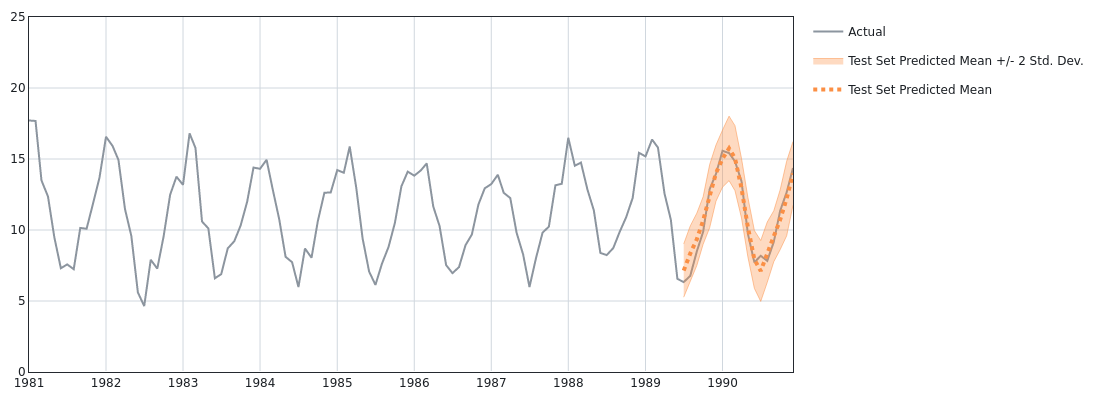

In [16]:
fig = go.Figure(
    layout=dict(
        paper_bgcolor="white",
        plot_bgcolor="white",
        margin=dict(t=10, b=10, l=10, r=10),
        legend=dict(font=dict(color="#1b1f24")),
        width=1100,
        height=400,
        xaxis=dict(
            mirror=True,
            linecolor="#24292f",
            gridcolor="#d0d7de",
            gridwidth=1,
            tickfont=dict(
                color="#1b1f24"
            ),
        ),
        yaxis=dict(
            range=[0, 25],
            mirror=True,
            linecolor="#24292f",
            gridcolor="#d0d7de",
            gridwidth=1,
            tickfont=dict(
                color="#1b1f24"
            ),
        ),
    ),
    data=[
        go.Scatter(
            x=df["Date"],
            y=df["Temp"],
            mode="lines",
            name="Actual",
            line=dict(
                color="#8c959f",
                width=2
            )
        ),
        go.Scatter(
            x=predictions["Date"],
            y=predictions["Mean"] + 2 * predictions["Std. Dev."],
            mode="lines",
            showlegend=False,
            line=dict(
                width=0.5, 
                color="#fb8f44",
            ),
            fillcolor="rgba(251, 143, 68, 0.33)",
            legendgroup="Test Set Predicted Mean +/- 2 Std. Dev.",
        ),
        go.Scatter(
            x=predictions["Date"],
            y=predictions["Mean"] - 2 * predictions["Std. Dev."],
            mode="lines",
            name="Test Set Predicted Mean +/- 2 Std. Dev.",
            legendgroup="Test Set Predicted Mean +/- 2 Std. Dev.",
            line=dict(
                width=0.5, 
                color="#fb8f44",
            ),
            fillcolor="rgba(251, 143, 68, 0.33)",
            fill="tonexty",
        ),
        go.Scatter(
            x=predictions["Date"],
            y=predictions["Mean"],
            mode="lines",
            name="Test Set Predicted Mean",
            line=dict(
                color="#fb8f44",
                width=4,
                dash="dot",
            )
        ),


    ]
)
fig.show("png")

Calculate the test error.

In [17]:
print("Mean Absolute Error (MAE):", round(mean_absolute_error(y_true=df["Temp"].iloc[-prediction_length:], y_pred=predictions["Mean"]), 2))
print("Root Mean Squared Error (RMSE):", round(root_mean_squared_error(y_true=df["Temp"].iloc[-prediction_length:], y_pred=predictions["Mean"]), 2))

Mean Absolute Error (MAE): 0.58
Root Mean Squared Error (RMSE): 0.67


### Inference

Generate the forecasts.

In [18]:
start = time.time()
transformers.set_seed(42)
yhat_future = model.predict(
    context=torch.from_numpy(df["Temp"].values),
    prediction_length=prediction_length,
    num_samples=num_samples
).detach().cpu().numpy().squeeze(axis=0)
end = time.time()
print(f"Inference time: {format(end - start, ',.2f')} seconds")

Inference time: 2.38 seconds


Organize the forecasts in a data frame.

In [19]:
forecasts = pd.DataFrame(
    data={
        "Mean": np.mean(yhat_future, axis=0),
        "Std. Dev.": np.std(yhat_future, ddof=1, axis=0),
    },
    index=pd.Series(
        data=pd.date_range(
            start=df["Date"].iloc[-1] + pd.tseries.offsets.MonthBegin(1),
            end=df["Date"].iloc[-1] + pd.tseries.offsets.MonthBegin(prediction_length),
            freq="MS"
        ),
        name="Date"
    )
).reset_index()

In [20]:
forecasts.head()

,Date,Mean,Std. Dev.
0,1991-01-01,15.517287,0.856018
1,1991-02-01,16.110432,0.817915
2,1991-03-01,15.519515,0.860548
3,1991-04-01,13.323360,0.913167
4,1991-05-01,10.240448,0.903526


Visualize the forecasts.

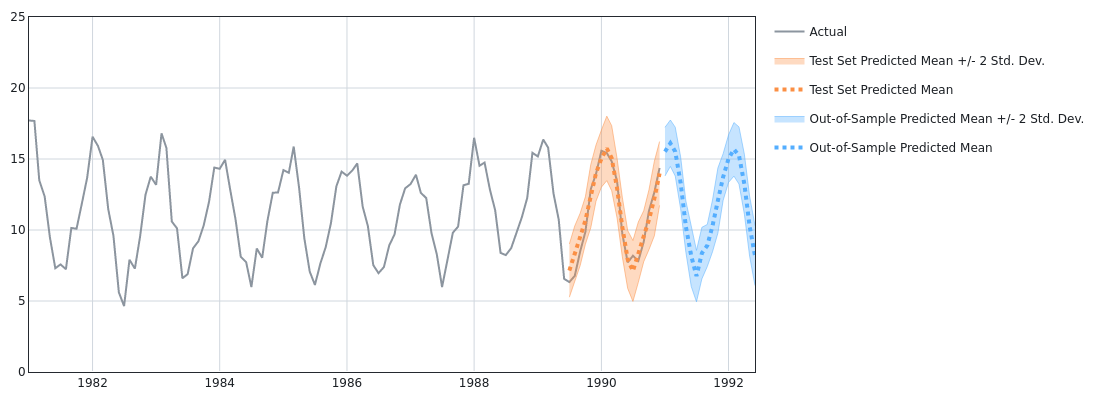

In [21]:
fig = go.Figure(
    layout=dict(
        paper_bgcolor="white",
        plot_bgcolor="white",
        margin=dict(t=10, b=10, l=10, r=10),
        legend=dict(font=dict(color="#1b1f24")),
        width=1100,
        height=400,
        xaxis=dict(
            mirror=True,
            linecolor="#24292f",
            gridcolor="#d0d7de",
            gridwidth=1,
            tickfont=dict(
                color="#1b1f24"
            ),
        ),
        yaxis=dict(
            range=[0, 25],
            mirror=True,
            linecolor="#24292f",
            gridcolor="#d0d7de",
            gridwidth=1,
            tickfont=dict(
                color="#1b1f24"
            ),
        ),
    ),
    data=[
        go.Scatter(
            x=df["Date"],
            y=df["Temp"],
            mode="lines",
            name="Actual",
            line=dict(
                color="#8c959f",
                width=2
            )
        ),
        go.Scatter(
            x=predictions["Date"],
            y=predictions["Mean"] + 2 * predictions["Std. Dev."],
            mode="lines",
            showlegend=False,
            line=dict(
                width=0.5, 
                color="#fb8f44",
            ),
            fillcolor="rgba(251, 143, 68, 0.33)",
            legendgroup="Test Set Predicted Mean +/- 2 Std. Dev.",
        ),
        go.Scatter(
            x=predictions["Date"],
            y=predictions["Mean"] - 2 * predictions["Std. Dev."],
            mode="lines",
            name="Test Set Predicted Mean +/- 2 Std. Dev.",
            legendgroup="Test Set Predicted Mean +/- 2 Std. Dev.",
            line=dict(
                width=0.5, 
                color="#fb8f44",
            ),
            fillcolor="rgba(251, 143, 68, 0.33)",
            fill="tonexty",
        ),
        go.Scatter(
            x=predictions["Date"],
            y=predictions["Mean"],
            mode="lines",
            name="Test Set Predicted Mean",
            line=dict(
                color="#fb8f44",
                width=4,
                dash="dot",
            )
        ),
        go.Scatter(
            x=forecasts["Date"],
            y=forecasts["Mean"] + 2 * forecasts["Std. Dev."],
            mode="lines",
            showlegend=False,
            line=dict(
                width=0.5, 
                color="#54aeff",
            ),
            fillcolor="rgba(84, 174, 255, 0.33)",
            legendgroup="Out-of-Sample Predicted Mean +/- 2 Std. Dev.",
        ),
        go.Scatter(
            x=forecasts["Date"],
            y=forecasts["Mean"] - 2 * forecasts["Std. Dev."],
            mode="lines",
            name="Out-of-Sample Predicted Mean +/- 2 Std. Dev.",
            legendgroup="Out-of-Sample Predicted Mean +/- 2 Std. Dev.",
            line=dict(
                width=0.5, 
                color="#54aeff",
            ),
            fillcolor="rgba(84, 174, 255, 0.33)",
            fill="tonexty",
        ),
        go.Scatter(
            x=forecasts["Date"],
            y=forecasts["Mean"],
            mode="lines",
            name="Out-of-Sample Predicted Mean",
            line=dict(
                color="#54aeff",
                width=4,
                dash="dot",
            )
        ),

    ]
)
fig.show("png")